In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

 94% 305M/325M [00:01<00:00, 176MB/s]
100% 325M/325M [00:02<00:00, 169MB/s]


In [ ]:
!unzip /content/skin-cancer-malignant-vs-benign.zip

In [ ]:
import glob
import random
import cv2
import os
from keras import layers
from keras import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from keras.callbacks import EarlyStopping, ModelCheckpoint

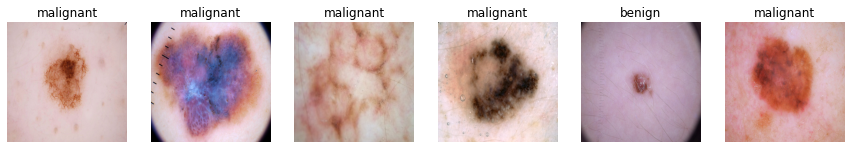

In [ ]:
w = 10
h = 10
fig = plt.figure(figsize=(15,10))
columns = 6
rows = 1
fielName = "/content/train"

for i in range(0, columns*rows ):
  index = random.randint(0,1)
  folderName = os.path.join((fielName), os.listdir(fielName)[index])
  img = cv2.imread(folderName+'/'+(os.listdir(os.path.join((fielName), os.listdir(fielName)[index]))[i]))
  fig.add_subplot(rows, columns, i+1)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.title(os.path.basename(folderName))

plt.show()

In [ ]:
def Convert_Data(c, label, dir_data):
    count = c
    if label == 0:
        label = 0
    else :
        label = 1
    for img_name in os.listdir(dir_data):
        img = cv2.imread(dir_data+"/"+img_name)
        img = cv2.resize(img, (224,224))
        img = np.array(img)/255.
        data.append(img)
        y_values.append(label)
        count += 1
    return count

In [ ]:
data = []
y_values = [] 

benign = 0
malignant = 1

count = 0
data1 = Convert_Data(count, benign, "/content/train/benign")
data2 = Convert_Data(data1, malignant, "/content/train/malignant")
data3 = Convert_Data(data2, benign, "/content/test/benign")
data4 = Convert_Data(data3, malignant, "/content/test/malignant")

In [ ]:
data = np.asarray(data).astype('float32')

In [ ]:
y_values = np.asarray(y_values).astype('float32')

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, y_values, test_size=0.2, random_state=5, shuffle=True)

In [ ]:
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

In [ ]:
!wandb login
wandb.init(project="Skin_Cancer", entity="manar")

wandb: Currently logged in as: manar. Use `wandb login --relogin` to force relogin


wandb: Currently logged in as: manar. Use `wandb login --relogin` to force relogin


## Fully Connected **Layer**

In [ ]:
X_train_flattened = x_train.reshape(len(x_train), 224*224, 3)
X_test_flattened = x_test.reshape(len(x_test), 224*224, 3)

In [ ]:
y_train_flattened = y_train.reshape(len(y_train), 1)
y_test_flattened = y_test.reshape(len(y_test), 1)

In [ ]:
X_train_flattened.shape

(2637, 50176, 3)

In [ ]:
y_train_flattened.shape

(2637, 1)

In [ ]:
# X_train_flattened = x_train.reshape(len(x_train), 224*224, 3)
# X_test_flattened = x_test.reshape(len(x_test), 224*224, 3)

In [ ]:
model_FC = Sequential()
model_FC.add(layers.Dense(128, input_shape=(224*224, 3), activation='relu'))
model_FC.add(layers.Dense(64, activation='relu'))
model_FC.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model_FC.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 50176, 128)        512       
                                                                 
 dense_4 (Dense)             (None, 50176, 64)         8256      
                                                                 
 dense_5 (Dense)             (None, 50176, 1)          65        
                                                                 
Total params: 8,833
Trainable params: 8,833
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_FC.compile(optimizer="adam", metrics="accuracy", loss="binary_crossentropy")

In [ ]:
callback = [ModelCheckpoint("/content/FC" ,
                            monitor='val_accuracy', mode='max', 
                            save_best_only=True)]

In [ ]:
model_FC.fit(X_train_flattened, y_train_flattened, validation_data=(X_test_flattened, y_test_flattened), epochs=30, callbacks=[callback, WandbCallback()])

Epoch 1/30
83/83 [==============================] - 12s 132ms/step - loss: 0.6593 - accuracy: 0.5788 - val_loss: 0.6168 - val_accuracy: 0.6261 - _timestamp: 1653178178.0000 - _runtime: 75.0000
Epoch 2/30
83/83 [==============================] - 10s 119ms/step - loss: 0.5964 - accuracy: 0.6863 - val_loss: 0.5673 - val_accuracy: 0.7564 - _timestamp: 1653178188.0000 - _runtime: 85.0000
Epoch 3/30
83/83 [==============================] - 9s 110ms/step - loss: 0.5563 - accuracy: 0.7201 - val_loss: 0.5336 - val_accuracy: 0.7326 - _timestamp: 1653178197.0000 - _runtime: 94.0000
Epoch 4/30
83/83 [==============================] - 9s 111ms/step - loss: 0.5389 - accuracy: 0.7301 - val_loss: 0.5240 - val_accuracy: 0.7307 - _timestamp: 1653178206.0000 - _runtime: 103.0000
Epoch 5/30
83/83 [==============================] - 11s 130ms/step - loss: 0.5283 - accuracy: 0.7344 - val_loss: 0.5185 - val_accuracy: 0.7566 - _timestamp: 1653178217.0000 - _runtime: 114.0000
Epoch 6/30
83/83 [=================

# FC with **EarlyStopping**

In [ ]:
model_FC2 = Sequential()
model_FC2.add(layers.Dense(128, input_shape=(224*224, 3), activation='relu'))
model_FC2.add(layers.Dense(64, activation='relu'))
model_FC2.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model_FC2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50176, 128)        512       
                                                                 
 dense_1 (Dense)             (None, 50176, 64)         8256      
                                                                 
 dense_2 (Dense)             (None, 50176, 1)          65        
                                                                 
Total params: 8,833
Trainable params: 8,833
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_FC2.compile(optimizer="adam", metrics="accuracy", loss="binary_crossentropy")

In [ ]:
callback = [ModelCheckpoint("/content/FC2" ,
                            monitor='val_accuracy', mode='max', 
                            save_best_only=True) ,
                    EarlyStopping(monitor='val_accuracy')]

In [ ]:
model_FC2.fit(X_train_flattened, y_train_flattened, validation_data=(X_test_flattened, y_test_flattened), epochs=30, callbacks=[callback, WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/30
83/83 [==============================] - 14s 128ms/step - loss: 0.6725 - accuracy: 0.5621 - val_loss: 0.6393 - val_accuracy: 0.5783 - _timestamp: 1653178861.0000 - _runtime: 33.0000
Epoch 2/30
83/83 [==============================] - 10s 120ms/step - loss: 0.6193 - accuracy: 0.6704 - val_loss: 0.5806 - val_accuracy: 0.7421 - _timestamp: 1653178871.0000 - _runtime: 43.0000


## **CNN**

In [ ]:
input_shape = (224, 224, 3)

model_CNN = Sequential()
model_CNN.add(layers.Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape,
                    activation= 'relu'))
model_CNN.add(layers.MaxPool2D(pool_size = (2, 2)))
model_CNN.add(layers.Dropout(0.25))

model_CNN.add(layers.Conv2D(64, kernel_size=(3, 3),padding = 'Same', 
                     activation ='relu'))
model_CNN.add(layers.MaxPool2D(pool_size = (2, 2)))
model_CNN.add(layers.Dropout(0.25))

model_CNN.add(layers.Flatten())
model_CNN.add(layers.Dense(128, activation='relu'))
model_CNN.add(layers.Dense(1, activation='sigmoid'))


In [ ]:
model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 56, 56, 64)       

In [ ]:
model_CNN.compile(optimizer="adam", metrics="accuracy", loss="binary_crossentropy")

In [ ]:
callback = [ModelCheckpoint("/content/CNN" ,
                            monitor='val_accuracy', mode='max', 
                            save_best_only=True)]

In [ ]:
model_CNN.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, callbacks=[callback, WandbCallback()])

Epoch 1/30
83/83 [==============================] - 10s 119ms/step - loss: 2.6187 - accuracy: 0.5540 - val_loss: 0.6899 - val_accuracy: 0.5636 - _timestamp: 1653163576.0000 - _runtime: 24.0000
Epoch 2/30
83/83 [==============================] - 9s 111ms/step - loss: 0.6108 - accuracy: 0.6276 - val_loss: 0.5344 - val_accuracy: 0.7379 - _timestamp: 1653163585.0000 - _runtime: 33.0000
Epoch 3/30
83/83 [==============================] - 9s 106ms/step - loss: 0.5014 - accuracy: 0.7573 - val_loss: 0.4587 - val_accuracy: 0.7939 - _timestamp: 1653163594.0000 - _runtime: 42.0000
Epoch 4/30
83/83 [==============================] - 9s 104ms/step - loss: 0.4195 - accuracy: 0.7884 - val_loss: 0.4014 - val_accuracy: 0.7924 - _timestamp: 1653163602.0000 - _runtime: 50.0000
Epoch 5/30
83/83 [==============================] - 7s 89ms/step - loss: 0.3863 - accuracy: 0.8100 - val_loss: 0.5392 - val_accuracy: 0.7167 - _timestamp: 1653163611.0000 - _runtime: 59.0000
Epoch 6/30
83/83 [======================

In [ ]:
# from keras.models import load_model

# model = load_model('/content/CNN')

# img = cv2.imread('/content/train/malignant/1023.jpg')
# img = cv2.resize(img,(224,224))
# img = np.reshape(img,[1,224,224,3])

# classes = model.predict(img)


In [ ]:
# classes[0][0] 

0.0

In [ ]:
import shutil
shutil.make_archive('/content/CNN', 'zip', '/content/CNN')
shutil.make_archive('/content/FC', 'zip', '/content/FC')

'/content/FC.zip'